# 多项式回归

我们之前做的线性回归都是把数据归一化到$y=w_1x_1+w_2x_2+...+w_nx_n$中，这样的做法经常只能得到线性的结果，因为划分区域划分特征的方式均使用直线。这个世界上往往存在着非线性的特征，就比如$y=w_1x^2+w_2x+w_3$这样的式子。

其实求上述那样的，仅仅把$x^2$也当成类似$x$那样同等地位的特征，但本质上依然使用乘上权重的做法。其实我们可以初始化，令$x_2:=x_1^2$，再带入原本的线性回归中即可。也就是将$y=w_1x_1^2+w_2x_1+w_3$的回归问题转化为求$y=w_1x_1+w_2x_2+w_3, x_1=x_2^2$的回归问题

## 生成散点图

在曲线$y=\frac{1}{2}x^2+x$基础上增加均值为0，方差0.5的扰动

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = np.random.uniform(-3, 3, size=100)
X = x.reshape(-1, 1)
y = 0.5 * x**2  + x + np.random.normal(0, 1, size=100)

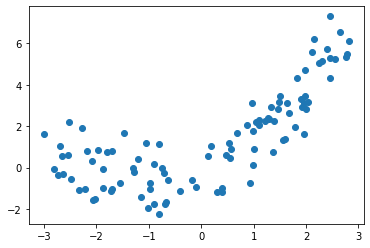

In [3]:
plt.scatter(x, y)
plt.show()

## 一维二维线性回归

### 一维线性回归
一维线性回归的做法很常规，直接调用库就好

In [4]:
from sklearn.linear_model import LinearRegression
one_dim_regression = LinearRegression()

In [5]:
one_dim_regression.fit(X, y)
y1 = one_dim_regression.predict(X)

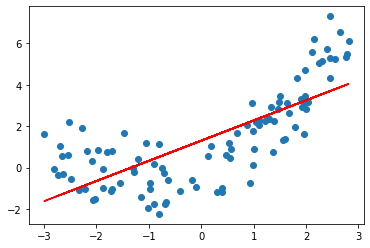

In [6]:
plt.scatter(x, y)
plt.plot(x, y1, color="red")
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, y1)

2.290220449518379

### 二维线性回归
二维线性回归需要用到上面的办法，将元素从一维的$\{x\}$，扩展到两维的$\{x, x^2\}$。

In [8]:
X2 = np.hstack([X, X**2])
two_dim_regression = LinearRegression()

In [9]:
two_dim_regression.fit(X2, y)
y2 = two_dim_regression.predict(X2)

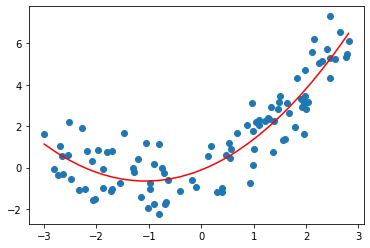

In [10]:
plt.scatter(x, y)
plt.plot(np.sort(x), y2[np.argsort(x)], color="red")
plt.show()

In [11]:
mean_squared_error(y, y2)

1.0077639285951798

我们看到，采用了均方根误差评估结果，MSE大幅度下降

## 高维度过拟合演示

这里学了两个工具方法PolynomialFeatures，以及pipeline。

### PolynomialFeatures
这里顺便演示PolynomialFeatures的用法，其实PolynomialFeatures就是通过一组数据X，通过多种组合，生成所有对应维度以下的所有特征。如果我们想像刚刚那样生成2维的特征，输入二维数据$\{x, y\}$，就会生成$\{x^2, xy, y^2, x, y, 1\}$

我这里为了演示过拟合，先生成一组五维的数据，输入一维数据$\{x\}$，会生成$\{x^0,x^1,x^2,x^3,x^4,x^5\}$，一共6个维度的数据

**演示**

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly_sample = PolynomialFeatures(degree=5)
poly_sample.fit(X)
X5 = poly_sample.transform(X)
X5.shape

(100, 6)

### pipeline演示

其实pipeline就是实现按顺序的批量操作用的，有点像pytorch的那些内容那样

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

high_lin_reg = LinearRegression()
pipe_reg = Pipeline([
    ("poly", PolynomialFeatures(degree=20)),
    ("std_scaler", StandardScaler()),
    ("lin_reg", high_lin_reg),
])
pipe_reg

Pipeline(steps=[('poly', PolynomialFeatures(degree=20)),
                ('std_scaler', StandardScaler()),
                ('lin_reg', LinearRegression())])

我个人的理解，Pipeline的fit方法就是依次执行他们的fit和transform方法，predict就是执行每个流程的transform方法，并在最后一个执行predict方法

In [14]:
pipe_reg.fit(X, y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=20)),
                ('std_scaler', StandardScaler()),
                ('lin_reg', LinearRegression())])

In [15]:
y5 = pipe_reg.predict(X)

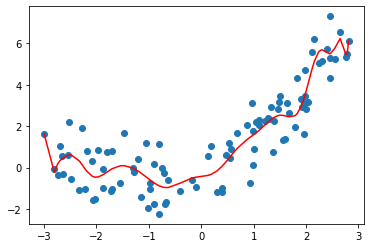

In [16]:
plt.scatter(x, y)
plt.plot(np.sort(x), y5[np.argsort(x)], color="red")
plt.show()

In [17]:
mean_squared_error(y, y5)

0.8571984820065167

此时我们可以看出，提高了特征维度之后，结果的MSE会增加，但这和我们实际生成的公式相差甚远，这就是过拟合的结果

## 正则化

我们先检查一下之前模型中，线性回归中每一项的参数是多少

In [19]:
high_lin_reg.coef_

array([ 0.00000000e+00,  4.59075286e-01,  4.83976500e-01,  6.19643905e+01,
        5.84438528e+01, -8.98540360e+02, -8.03210201e+02,  6.54765128e+03,
        6.15602994e+03, -2.79765399e+04, -2.82339097e+04,  7.37534726e+04,
        7.85691593e+04, -1.21072951e+05, -1.33535417e+05,  1.20418725e+05,
        1.35553833e+05, -6.63870065e+04, -7.55499208e+04,  1.55633881e+04,
        1.77947048e+04])

看里面的数据，很多比较离谱的数据都是E4甚至E5的，明显是不对的。我们可以通过正则化的手段限制值的大小